Notebook to prompt models to assist in information extraction of arguments from ToC.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

toc_df = pd.read_csv("/content/drive/MyDrive/LLM/extracted_briefs+toc.csv")
print(f"There are {len(toc_df)} rows in the dataset")

There are 14581 rows in the dataset


In [ ]:
# The first row is fucked for some reason so remove it
toc_df = toc_df.iloc[1:].reset_index(drop=True)

In [ ]:
# some additional cleaning after manual inspection of data

# toc_df['text'] = toc_df['text'].str.replace('â', "'", regex=False)
# toc_df['toc'] = toc_df['toc'].str.replace('â', "'", regex=False)
# toc_df['content'] = toc_df['content'].str.replace('â', "'", regex=False)
# Truncate strings in the 'toc' column to a maximum of n
toc_df['toc'] = toc_df['toc'].apply(lambda x: x if len(x) <= 4000 else x[:4000])
# del toc_df['merit_case']


In [ ]:
# toc_df.to_csv("/content/drive/MyDrive/LLM/extracted_briefs+toc_2.csv")

In [ ]:
print(toc_df.head)

<bound method NDFrame.head of        Unnamed: 0                                               text  \
0               1  b'No. 21-2\nIN THE\n\nSupreme Court of the Uni...   
1               2  b'No. 21-2\nIN THE\n\nSupreme Court of the Uni...   
2               3  b"No. _____\n\nIn the\nSupreme Court of the Un...   
3               4  b"No. _______\nIn The\n\nSupreme Court of the ...   
4               5  b'No. ___-______\n\nIn The\n\nSupreme Court of...   
...           ...                                                ...   
14575       14576  b"No.19-1355\nIN THE SUPREME COURT OF THE UNIT...   
14576       14577  b'No. _________\n=============================...   
14577       14578  b'No. _________\n\nIn the Supreme Court of the...   
14578       14579  b'No. 19-1359\n\nIN THE\n\n6upretne Court of t...   
14579       14580  b'No. 19â1360\n\nIn the Supreme Court of the...   

      created_timestamp downloaded_timestamp  \
0            08-02-2021           10-19-2021   
1        

Use this to find merit cases

In [ ]:
'''
merit_df = toc_df[~(toc_df['toc'].str.contains('certiorari', case=False, na=False )|
                   toc_df['text'].str.contains('amicus', case=False, na=False) |
                   toc_df['text'].str.contains('petition', case=False, na=False)
                   )]
print(len(merit_df))
'''

"\nmerit_df = toc_df[~(toc_df['toc'].str.contains('certiorari', case=False, na=False )|\n                   toc_df['text'].str.contains('amicus', case=False, na=False) |\n                   toc_df['text'].str.contains('petition', case=False, na=False)\n                   )]\nprint(len(merit_df))\n"

In [ ]:
# print(merit_df.iloc[100]['content'])

pile of law only has data from 2020 and 2021, which explains a lot.

In [ ]:
search_df = toc_df[toc_df['docket_num'] == '09-479']
print(len(search_df))

0


Apply more regex preprocessing to remove extra content. Hopefully this makes the extraction easier for the model later.

Truncating, and cleaning seems to work with the first example, try with a few others.

In [ ]:
import re
def clean_table_of_contents(text):
    # Stage 1: Remove periods and page numbers
    # text = re.sub(r' +\d+\n', '\n', text)  # Remove page numbers
    # Remove standalone numbers without a period. Must do this before removing periods below.
    text = re.sub(r'^\s*\d+\s*$', '', text, flags=re.MULTILINE)
    # text = re.sub(r'\.{2,}', ' ', text)  # Replace periods
    text = re.sub(r'\.{3,}.*$', '', text, flags=re.MULTILINE) # Same as above
    text = re.sub(r'(\.\s){2,}.*$', '', text, flags=re.MULTILINE)

    # Stage 2: Use re.search to find "CONCLUSION" on a line by itself, case-insensitive
    conclusion_match = re.search(r'^CONCLUSION\s*$', text, flags=re.MULTILINE | re.IGNORECASE)
    if conclusion_match:
        # If a match is found, slice the text up to the start of the match
        text = text[:conclusion_match.start()]

    # Remove lowercase Roman numerals at the end of lines, ensuring they're not part of section titles
    text = re.sub(r'\b(i{1,3}|iv|v?i{0,3}|ix|x{1,2}|x{1}v|x{1}i{1,3}|x{1}ix)\b(?![A-Z])\.?\s*$', '', text, flags=re.MULTILINE)

    return text

In [ ]:
test_toc = toc_df.iloc[22]['toc']
print(test_toc)

TABLE OF CONTENTS
Page
Question Presented .............................................

i

List of Parties ......................................................

ii

Table of Authorities .............................................

iv

Statutory and Regulatory Provisions Involved .....

1

Statement of the Case .........................................

3

A.

Factual Background ..................................

3

1. Investigation and Placement on Administrative Leave ..............................

4

2. Ross's Term Contract Non-renewal
Hearing ................................................ 10
3. Texas Commissioner of Education Denies Ross's Appeal ............................... 13
4. Procedural History .............................. 16
Reasons for Denying Petition .............................. 17
A.

No Important Federal Question is Presented; Ross's Property Interests Were
Not Implicated When Her Employment
Contract Was Not Renewed ....................... 17

B.

Ross Rec

In [ ]:
# Example input
toc_text = test_toc

# Clean the table of contents
cleaned_toc = clean_table_of_contents(toc_text)
print(cleaned_toc)

TABLE OF CONTENTS
Page
Question Presented

List of Parties

Table of Authorities

Statutory and Regulatory Provisions Involved
Statement of the Case
A
Factual Background
1. Investigation and Placement on Administrative Leave
2. Ross's Term Contract Non-renewal
Hearing
3. Texas Commissioner of Education Denies Ross's Appeal
4. Procedural History
Reasons for Denying Petition
A
No Important Federal Question is Presented; Ross's Property Interests Were
Not Implicated When Her Employment
Contract Was Not Renewed
B
Ross Received All the Process She Was
Due


In [ ]:
regex_toc_df = toc_df['toc'].apply(clean_table_of_contents) # Apply regex to the whole column, save as new df to test

Look at some examples for how the regex worked

In [ ]:
idx = 3
print(toc_df.iloc[idx]['toc'])

TABLE OF CONTENTS
Page
QUESTION PRESENTED .......................................... i
PARTIES TO THE PROCEEDING ........................... ii
RULE 29.6 DISCLOSURE STATEMENT ................iii
RELATED PROCEEDINGS .....................................iii
TABLE OF CONTENTS............................................ iv
TABLE OF AUTHORITIES .................................... viii
OPINIONS BELOW ................................................... 2
JURISDICTION ......................................................... 2
CONSTITUTIONAL
AND
STATUTORY
PROVISIONS INVOLVED......................................... 3
INTRODUCTION ....................................................... 6
STATEMENT OF THE CASE ................................. 10
A.

Background ............................................... 10

B.

Constitutional objections .......................... 11

C.

Evidentiary Hearing on Motion to
Quash ........................................................ 13

D.

Trial Court Judg

In [ ]:
print(regex_toc_df.iloc[idx])

TABLE OF CONTENTS
Page
QUESTION PRESENTED
PARTIES TO THE PROCEEDING
RULE 29.6 DISCLOSURE STATEMENT
RELATED PROCEEDINGS
TABLE OF CONTENTS
TABLE OF AUTHORITIES
OPINIONS BELOW
JURISDICTION
CONSTITUTIONAL
AND
STATUTORY
PROVISIONS INVOLVED
INTRODUCTION
STATEMENT OF THE CASE
A
Background
B
Constitutional objections
C
Evidentiary Hearing on Motion to
Quash
D
Trial Court Judgment, denying the
Motion to Quash
E
Certification of Interlocutory Appeal
F
Supreme Court of Virginia Appeal

REASONS FOR GRANTING THE WRIT
I
This Court clearly has jurisdiction,
unless it determines that the
November 30, 2020, judgment, which
employed
language
historically
construed as being an adverse
summary adjudication on the merits,
is no longer such due to section âDâ of
Va. Code Â§8.01-670.1, enacted July 1,
2020. That is not clearly the case, so
this Petition is filed
A
This Court has jurisdiction
over final judgments of a
state's highest court on
discrete federal questions,
even if actions are continuing
aga

In [ ]:
idx = 33
print(toc_df.iloc[idx]['toc'])

TABLE OF CONTENTS
Table of Authorities .....................................................ii
Interest of Amici Curiae .............................................. 1
Summary of Argument ................................................ 1
Argument ..................................................................... 4
I.

The Doctrine of Forum Non Conveniens,
in its Application by Federal Courts, is
Marred by Inconsistency ................................ 4
A. The appellate courts disagree over the
deference due a plaintiff's forum choice .... 4
B. The defendant's burden has not been
consistently articulated or applied by
the appellate and district courts ................ 8
C. The lower courts disagree in their
weighing of public and private
factors and on the imposition of
dismissal conditions .................................... 9
D. Courts are divided with respect to
the choice of law analysis. ....................... 10

II. The Court Should Take this Opportunity to
Revisit the Do

In [ ]:
print(regex_toc_df.iloc[idx])

TABLE OF CONTENTS
Table of Authorities
Interest of Amici Curiae
Summary of Argument
Argument
I
The Doctrine of Forum Non Conveniens,
in its Application by Federal Courts, is
Marred by Inconsistency
A. The appellate courts disagree over the
deference due a plaintiff's forum choice
B. The defendant's burden has not been
consistently articulated or applied by
the appellate and district courts
C. The lower courts disagree in their
weighing of public and private
factors and on the imposition of
dismissal conditions
D. Courts are divided with respect to
the choice of law analysis
II. The Court Should Take this Opportunity to
Revisit the Doctrine
A. Proposals for reform
B. Proposals and grounds for
abandonment


In [ ]:
idx = 10000
print(toc_df.iloc[idx]['toc'])

TABLE OF CONTENTS
TABLE OF AUTHORITIES. . . . . . . . . . . . . . . . . . . iii
INTEREST OF AMICI CURIAE . . . . . . . . . . . . . . . . 1
INTRODUCTION AND SUMMARY
OF ARGUMENT . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3
ARGUMENT . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4
I.

STUDENT AMICI HAVE CHALLENGED A
VARIETY OF UNCONSTITUTIONAL
CAMPUS POLICIES ACROSS THE
NATION. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4
A. Unconstitutional speech zones and
permitting policies may only generate
nominal damages rather than out-ofpocket costs that can be alleged or
recovered as damages . . . . . . . . . . . . . . . . 6
B. Some permit requirements also
necessitate payment of a âsecurity feeâ by
the student group hosting an event . . . . . 9
C. Unfettered discretion, leading to
constitutionally prohibited viewpoint
discrimination, is a common theme in
Student Amici challenges . . . . . . . . . . . . 10

II.

REMEDIES FOR NOMINAL DAMAGES
ARE IMPO

In [ ]:
print(regex_toc_df.iloc[idx])

TABLE OF CONTENTS
TABLE OF AUTHORITIES
INTEREST OF AMICI CURIAE
INTRODUCTION AND SUMMARY
OF ARGUMENT
ARGUMENT
I
STUDENT AMICI HAVE CHALLENGED A
VARIETY OF UNCONSTITUTIONAL
CAMPUS POLICIES ACROSS THE
NATION
A. Unconstitutional speech zones and
permitting policies may only generate
nominal damages rather than out-ofpocket costs that can be alleged or
recovered as damages
B. Some permit requirements also
necessitate payment of a âsecurity feeâ by
the student group hosting an event
C. Unfettered discretion, leading to
constitutionally prohibited viewpoint
discrimination, is a common theme in
Student Amici challenges
II
REMEDIES FOR NOMINAL DAMAGES
ARE IMPORTANT TO FACILITATE
REVISION OF UNCONSTITUTIONAL
POLICIES ON CAMPUS AND DETER
FUTURE VIOLATIONS

A. Nominal damages confer prevailing party
status entitling the plaintiff to attorney
feesâa powerful remedy to deter future
violations
B. Remedies for completed constitutional
violations expedite lasting policy changes
that ensure free

In [ ]:
idx = 12993
print(toc_df.iloc[idx]['toc'])

TABLE OF CONTENTS

Page

QUESTIONS PRESENTED ...................................

i

PARTIES TO THE PROCEEDING AND RULE
29.6 STATEMENT ...............................................

ii

RULE 14.3(b)(iii) STATEMENT ............................

iii

TABLE OF AUTHORITIES....................................

vii

OPINIONS BELOW ................................................

1

JURISDICTION .......................................................

1

CONSTITUTIONAL AND STATUTORY PROVISIONS INVOLVED ..........................................

1

STATEMENT OF THE CASE ................................

2

A. Factual Background ....................................

4

B. Proceedings Below.......................................

5

REASONS FOR GRANTING THE PETITION....

7

I. SCARBOROUGH'S COMMERCE
CLAUSE ANALYSIS IS NO LONGER
VIABLE AFTER LOPEZ................................

7

A. Courts and judges acknowledge that the
two decisions are irreconcilable .................

7

B. The decisio

In [ ]:
print(toc_df.iloc[idx]['url'])

http://www.supremecourt.gov/DocketPDF/20/20-6791/165363/20210104183852431_Penn%20Cert%20Petition%20Final.pdf


In [ ]:
print(regex_toc_df.iloc[idx])

TABLE OF CONTENTS
Page
QUESTIONS PRESENTED

PARTIES TO THE PROCEEDING AND RULE
29.6 STATEMENT

RULE 14.3(b)(iii) STATEMENT

TABLE OF AUTHORITIES

OPINIONS BELOW
JURISDICTION
CONSTITUTIONAL AND STATUTORY PROVISIONS INVOLVED
STATEMENT OF THE CASE
A. Factual Background
B. Proceedings Below
REASONS FOR GRANTING THE PETITION
I. SCARBOROUGH'S COMMERCE
CLAUSE ANALYSIS IS NO LONGER
VIABLE AFTER LOPEZ
A. Courts and judges acknowledge that the
two decisions are irreconcilable
B. The decision below is wrong
1. Scarborough's broad reading of the
commerce power is fundamentally at
odds with federalist principles
2. Section 922(g)'s possession element
should require participation in, or a
substantial effect on interstate commerce

TABLE OF CONTENTSâcontinued
3. The plain meaning of the nexus element of Â§ 922(g)'s possession crime
does not support the prevailing interpretation
Page
C. This case presents an ideal vehicle to
overrule Scarborough
D. Federal overreach under Â§ 922(g) is an
important 

The graph shows that there is still a long tail of excessively long token lengths, so I'll need to truncate them to around 3000 like I did before.

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Assuming toc_df is your DataFrame and it has a column named 'toc'

# Step 2: Load the Mistral tokenizer
# Replace 'mistral-model-name' with the actual name of the Mistral model you intend to use
tokenizer = AutoTokenizer.from_pretrained('Open-Orca/Mistral-7B-OpenOrca')

# Step 3: Tokenize the strings and calculate token lengths
token_lengths = regex_toc_df.apply(lambda x: len(tokenizer.tokenize(x)))

# Step 4: Plot a histogram of the token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Lengths After Cleaning with Regex')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


NameError: name 'regex_toc_df' is not defined

Apply truncation and save the new df

In [ ]:
regex_toc_df = regex_toc_df.apply(lambda x: x if len(x) <= 4000 else x[:4000])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


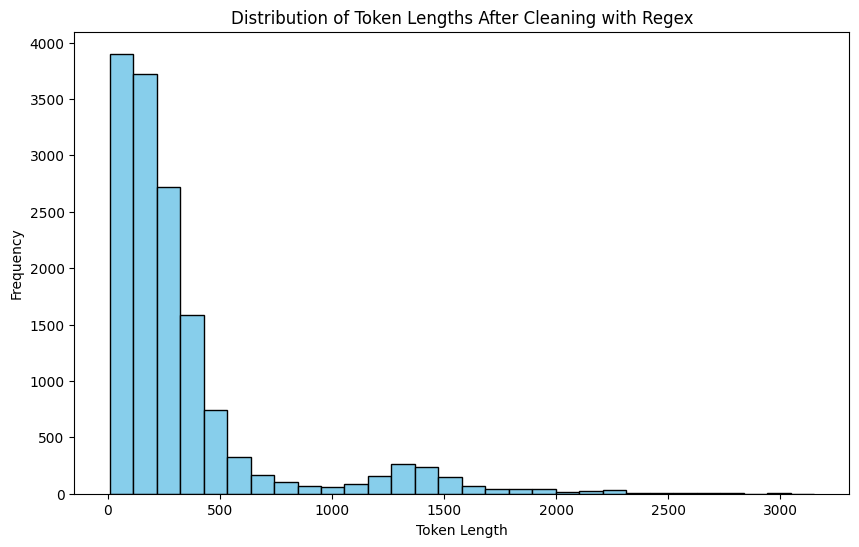

In [ ]:
# Check the token lengths after truncation
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Assuming toc_df is your DataFrame and it has a column named 'toc'

# Step 2: Load the Mistral tokenizer
# Replace 'mistral-model-name' with the actual name of the Mistral model you intend to use
tokenizer = AutoTokenizer.from_pretrained('Open-Orca/Mistral-7B-OpenOrca')

# Step 3: Tokenize the strings and calculate token lengths
token_lengths = regex_toc_df.apply(lambda x: len(tokenizer.tokenize(x)))

# Step 4: Plot a histogram of the token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Lengths After Cleaning with Regex')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
toc_df['toc'] = toc_df['toc'].apply(clean_table_of_contents)

In [ ]:
toc_df.to_csv("/content/drive/MyDrive/LLM/extracted_briefs+toc_3.csv")

Confirm the token length of the few shot prompt

In [ ]:
file_path = '/content/drive/MyDrive/LLM/few_shot_prompt_short.txt'

# Read the text file into a string
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Split the string into tokens based on whitespace
tokens = text.split()

# Print the number of tokens
print(f"Number of tokens in the text: {len(tokens)}")
print(text)

Number of tokens in the text: 1889
Consider the following example inputs and outputs for how to extract arguments from a table of contents from a legal brief. 
Instructions for a text extraction task will follow after the examples.
<Examples Start>
<Example Input 1>
TABLE OF CONTENTS
COUNTERSTATEMENT OF QUESTION
PRESENTED .............................................................. i
OPPOSITION TO PETITION FOR A WRIT
OF CERTIORARI ........................................................1
STATEMENT OF THE CASE ....................................2
A. Statutory and Factual Background .................2
B. Procedural History ...........................................5
REASONS FOR DENYING THE PETITION............8
I.

THE DECISION BELOW IS ENTIRELY
CONSISTENT WITH THIS COURT'S
PRECEDENTS ....................................................8
A. The Courts Below Correctly Applied Chevron Deference to PBGC's Interpretations of
ERISA in its Benefit Determination ............ 9
B. The Co

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


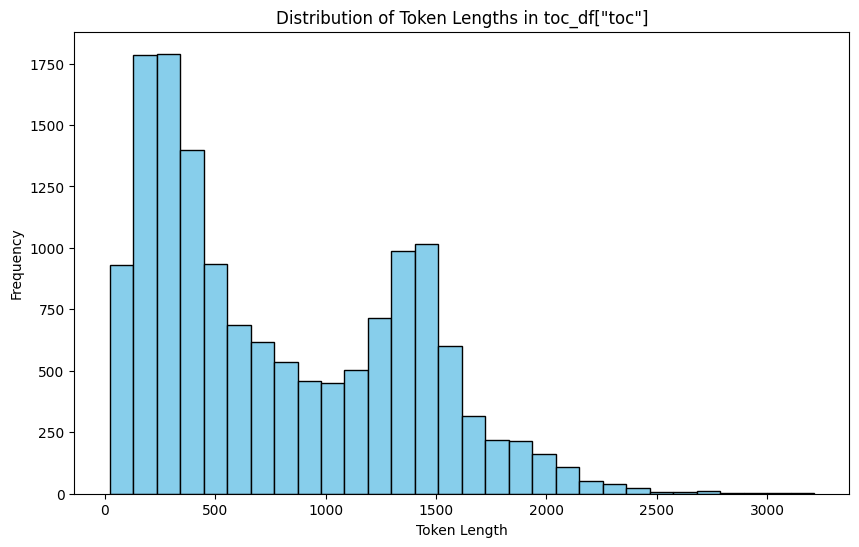

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Assuming toc_df is your DataFrame and it has a column named 'toc'

# Step 2: Load the Mistral tokenizer
# Replace 'mistral-model-name' with the actual name of the Mistral model you intend to use
tokenizer = AutoTokenizer.from_pretrained('Open-Orca/Mistral-7B-OpenOrca')

# Step 3: Tokenize the strings and calculate token lengths
token_lengths = toc_df['toc'].apply(lambda x: len(tokenizer.tokenize(x)))

# Step 4: Plot a histogram of the token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Lengths in toc_df["toc"]')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
check_idx = 7
to_check = toc_df.iloc[check_idx]['toc']
print(f"The string length is: {len(to_check)}")
print(to_check[:4000])

The string length is: 4000
TABLE OF CONTENTS
Page
QUESTIONS PRESENTED ................................

i

PARTIES TO THE PROCEEDINGS BELOW .....

ii

RELATED PROCEEDINGS ................................

ii

TABLE OF AUTHORITIES .................................

v

PETITION FOR A WRIT OF CERTIORARI .......

1

OPINIONS AND ORDERS BELOW....................

1

JURISDICTION ...................................................

1

CONSTITUTIONAL AND STATUTORY PROVISIONS INVOLVED...........................................

2

STATEMENT OF THE CASE..............................

3

Introduction .........................................................

3

Facts .....................................................................

5

Proceedings Below ...............................................

9

REASONS FOR GRANTING THE WRIT............ 12
I.

THERE IS A CLEAR SPLIT AMONG THE
CIRCUIT COURTS OF APPEALS ABOUT
WHETHER THE INTENT-TO-HARM
STANDARD OF LIABILITY APPLIES TO
ALL POLICE HIGH-

In [ ]:
print(f"the number of tokens at index {check_idx} is: {token_lengths.iloc[check_idx]}")

the number of tokens at index 33 is: 379


In [ ]:
text_to_tokenize = toc_df['toc'].iloc[check_idx]

# Tokenize the text
tokens = tokenizer.tokenize(text_to_tokenize)

# Print the tokens
print(f"Tokens at index {check_idx}:")
for token in tokens:
  print(f"{token}")

Tokens at index 33:
▁TABLE
▁OF
▁CON
T
ENT
S
<0x0A>
TABLE
▁OF
▁AUTH
OR
IT
IES
▁
................
................
...
▁i
ii
<0x0A>
INTER
EST
▁OF
▁AM
IC
US
▁C
UR
IA
E
▁
................
........
..
1
<0x0A>
S
UM
M
ARY
▁OF
▁AR
G
UMENT
................
................
...
2
<0x0A>
ARG
UMENT
▁
................
................
................
........
.....
5
<0x0A>
I
.
▁The
▁Third
▁Circ
uit
'
s
▁mis
gu
ided
▁application
▁of
<0x0A>
for
um
▁non
▁conven
iens
▁shows
▁that
▁courts
<0x0A>
l
ack
▁clear
▁guidance
▁on
▁the
▁application
▁of
<0x0A>
this
▁doctrine
▁
................
................
................
........
..
5
<0x0A>
A
.
▁Cour
ts
▁lack
▁a
▁clear
▁framework
▁to
<0x0A>
evalu
ate
▁evidence
▁of
▁corruption
▁in
▁foreign
<0x0A>
c
our
ts
,
▁especially
▁in
▁the
▁Latin
▁American
<0x0A>
context
.
▁
................
................
................
........
....
..
5
<0x0A>
B
.
▁The
▁Third
▁Circ
uit
▁dis
reg
arded
▁a
▁proven
,
<0x0A>
ongo
ing
▁pattern
▁of
▁jud
icial
▁corruption
▁in
<0x0A>
